Начальный анализ данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import seaborn as sns
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

Конфигурационные переменные

In [46]:
DATASET_PATH = "../data/raw/labeled.csv"
SAVE_PROCESSED_PATH = "../data/processed/raw_features_extracted.csv"
SEED = 42
np.random.seed(SEED)

TOKEN_PATTERN = "[а-яёa-z]+"
SIGN_PATTERN = r'[!?*@#$&%^:;"\')(~`0-9]'
URL_PATTERN = r'https?://\S+|www\.\S+'
REPEATED_PATTERN = r'(.)\1{2,}'
PRONOUNS = ['я', 'ты', 'вы', 'он', 'она', 'оно', 'мы', 'они', 'вас', 'нас', 'их', 'его', 'её']


Считываем датасет

In [17]:
def read_dataset(data_path: str = DATASET_PATH):
    dataset = pd.read_csv(data_path)
    return dataset

comments_dataset = read_dataset()
comments_dataset.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


Информация об исходном датасете

In [18]:
comments_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


In [19]:
comments_dataset.describe()

,toxic
count,14412.000000
mean,0.334860
std,0.471958
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Баланс классов

In [20]:
print(f"Количество токсичных (агрессивных) комментариев: {len(comments_dataset[comments_dataset['toxic'] == 1])}")
print(f"Количество нейтральных (адекватных) комментариев: {len(comments_dataset[comments_dataset['toxic'] == 0])}")

Количество токсичных (агрессивных) комментариев: 4826
Количество нейтральных (адекватных) комментариев: 9586


Итак, присутствует явный дисбаланс классов. Необходима будет аугментация данных.

Посмотрим на статистики текстов:

1) Длина текста в зависимости от агрессивности / нейтральности

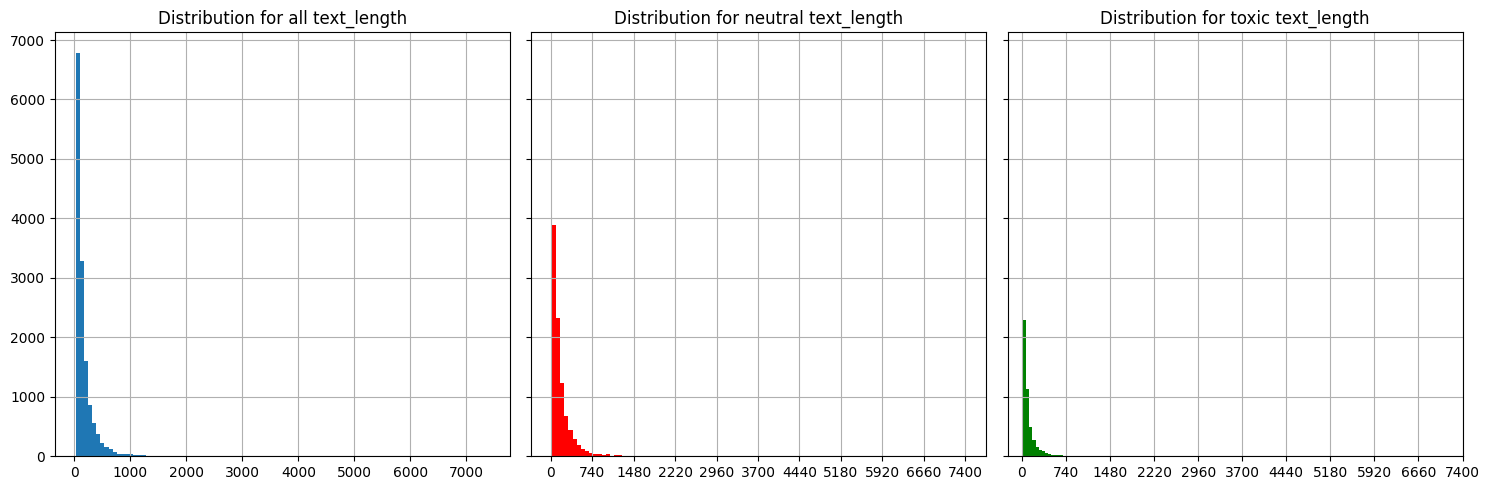

In [21]:
comments_dataset['text_length'] = comments_dataset.comment.str.len()

def plot_distribution(dataset: pd.DataFrame = comments_dataset, column: str = 'text_length'):
    figure, axs = plt.subplots(1, 3, sharey=True, figsize = (15, 5))

    lens_positive_class = dataset.query('toxic == 0')[column].values
    lens_negative_class = dataset.query('toxic == 1')[column].values


    axs[0].hist(dataset['text_length'], bins = 100)
    axs[0].set_title(f'Distribution for all {column}')
    axs[0].grid(True)

    axs[1].hist(lens_positive_class, bins = 100, color = 'red')
    axs[1].set_title(f'Distribution for neutral {column}')
    axs[1].grid(True)

    axs[2].hist(lens_negative_class, bins = 100, color = 'green')
    axs[2].set_title(f'Distribution for toxic {column}')
    axs[2].grid(True)

    max_value = max(dataset[column].max(), 1) 
    step = max_value // 10  
    xticks = range(0, max_value + 1, step) 

    axs[1].set_xticks(xticks)
    axs[2].set_xticks(xticks)

    plt.tight_layout()
    plt.show()

plot_distribution()

In [22]:
comments_dataset_avg_len = comments_dataset.groupby('toxic').mean('text_length')['text_length']
comments_dataset_avg_len.head()

toxic
0.0    194.213332
1.0    141.392665
Name: text_length, dtype: float64

Средняя длина разная у токсичных и нетоксичных текстов

Хотя это несильная разница, на первый взгляд

2. Специальный символы (!№#$ и т.п.)

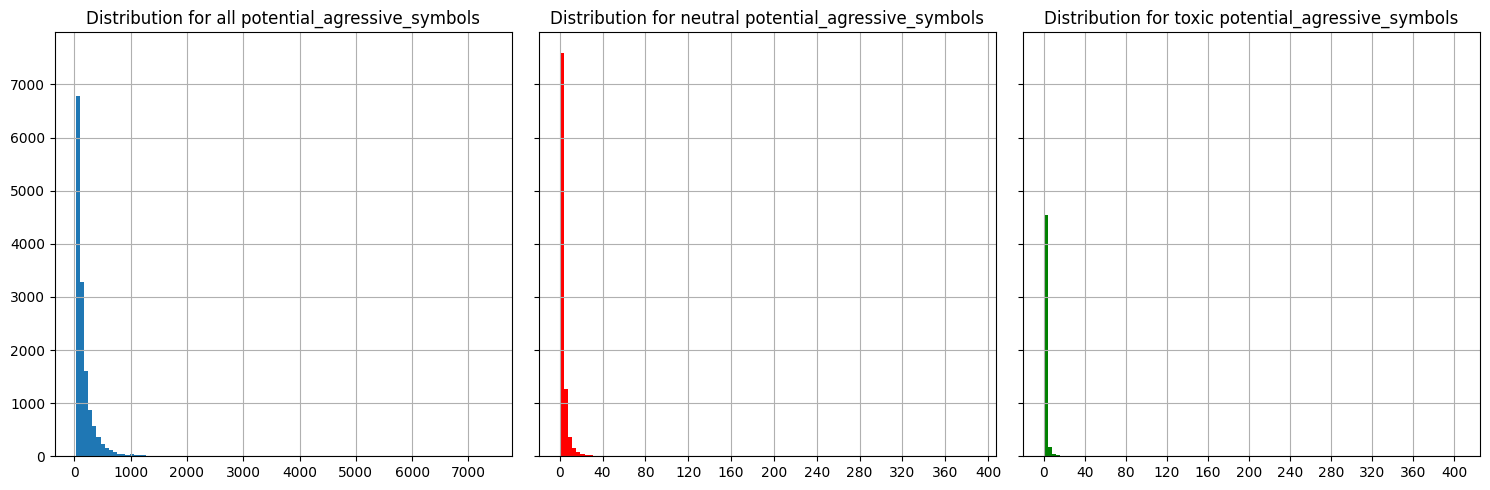

In [23]:
def count_special_characters(text):
    return len(re.findall(SIGN_PATTERN, text))

comments_dataset['potential_agressive_symbols'] = comments_dataset['comment'].apply(count_special_characters)
plot_distribution(column='potential_agressive_symbols')

In [24]:
comments_dataset_avg_num_symbols = comments_dataset.groupby('toxic').mean('potential_agressive_symbols')['potential_agressive_symbols']
comments_dataset_avg_num_symbols.head()

toxic
0.0    2.492802
1.0    1.368835
Name: potential_agressive_symbols, dtype: float64

Здесь уже имеется какая-то разница в распределениях. Можно как-то и зашить эту логику в модель

3. Посмотрим на количество слов по разделителям

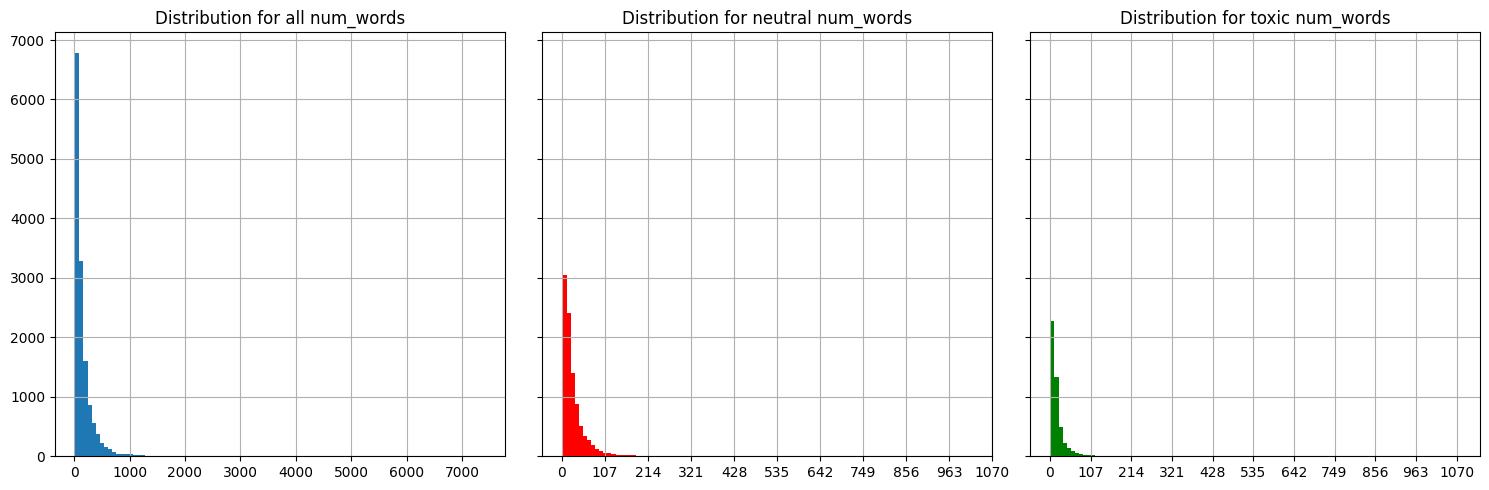

In [25]:
def count_words(text: str):
    return len(text.split())

comments_dataset['num_words'] = comments_dataset['comment'].apply(lambda x: count_words(x))

plot_distribution(column='num_words')

In [26]:
comments_dataset_avg_num_symbols = comments_dataset.groupby('toxic').mean('num_words')['num_words']
comments_dataset_avg_num_symbols.head()

toxic
0.0    30.713436
1.0    22.449026
Name: num_words, dtype: float64

Тоже несильная разница

4. Посмотрим на другие эвристики

In [35]:
# Подсчет url в текстах
def count_links(text):
    return len(re.findall(URL_PATTERN, text))

# Анализ частоты повторяющихся символов
def count_repeated_chars(text):
    return len(re.findall(REPEATED_PATTERN, text))

# Количество местоимений в тексте
def count_pronouns(text):
    pronouns = ['я', 'ты', 'вы', 'он', 'она', 'оно', 'мы', 'они', 'вас', 'нас', 'их', 'его', 'её']
    tokens = word_tokenize(text.lower())  
    return sum(1 for word in tokens if word in pronouns)

# Средняя длина слова
def average_word_length(text):
    words = text.split()  
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)

# CAPS символы
def count_uppercase_chars(text):
    return sum(1 for char in text if char.isupper())

comments_dataset['link_count'] = comments_dataset['comment'].apply(count_links)
comments_dataset['repeated_chars_count'] = comments_dataset['comment'].apply(count_repeated_chars)
comments_dataset['pronoun_count'] = comments_dataset['comment'].apply(count_pronouns)
comments_dataset['avg_word_length'] = comments_dataset['comment'].apply(average_word_length)
comments_dataset['caps_symbols'] = comments_dataset['comment'].apply(count_uppercase_chars)

Теперь смотрим на результаты

1. URL count:

In [30]:
comments_dataset_link_count = comments_dataset.groupby('toxic').mean('link_count')['link_count']
comments_dataset_link_count.head()

toxic
0.0    0.000522
1.0    0.000207
Name: link_count, dtype: float64

2. Повторяющиеся символы

In [31]:
comments_dataset_repeated_symbols = comments_dataset.groupby('toxic').mean('repeated_chars_count')['repeated_chars_count']
comments_dataset_repeated_symbols.head()

toxic
0.0    0.145316
1.0    0.139660
Name: repeated_chars_count, dtype: float64

3. Местоимения

In [32]:
comments_dataset_pron = comments_dataset.groupby('toxic').mean('pronoun_count')['pronoun_count']
comments_dataset_pron.head()

toxic
0.0    0.742541
1.0    0.869664
Name: pronoun_count, dtype: float64

4. Средняя длина слова

In [33]:
comments_dataset_avg_word_len = comments_dataset.groupby('toxic').mean('avg_word_length')['avg_word_length']
comments_dataset_avg_word_len.head()

toxic
0.0    5.312308
1.0    5.467866
Name: avg_word_length, dtype: float64

5. Uppercase символы

In [36]:
comments_dataset_uppercase_count = comments_dataset.groupby('toxic').mean('caps_symbols')['caps_symbols']
comments_dataset_uppercase_count.head()

toxic
0.0    3.984978
1.0    6.595939
Name: caps_symbols, dtype: float64

Итак, предварительный feature инжиниринг завершен. Посмотрим на результаты

1. Попарные распределения

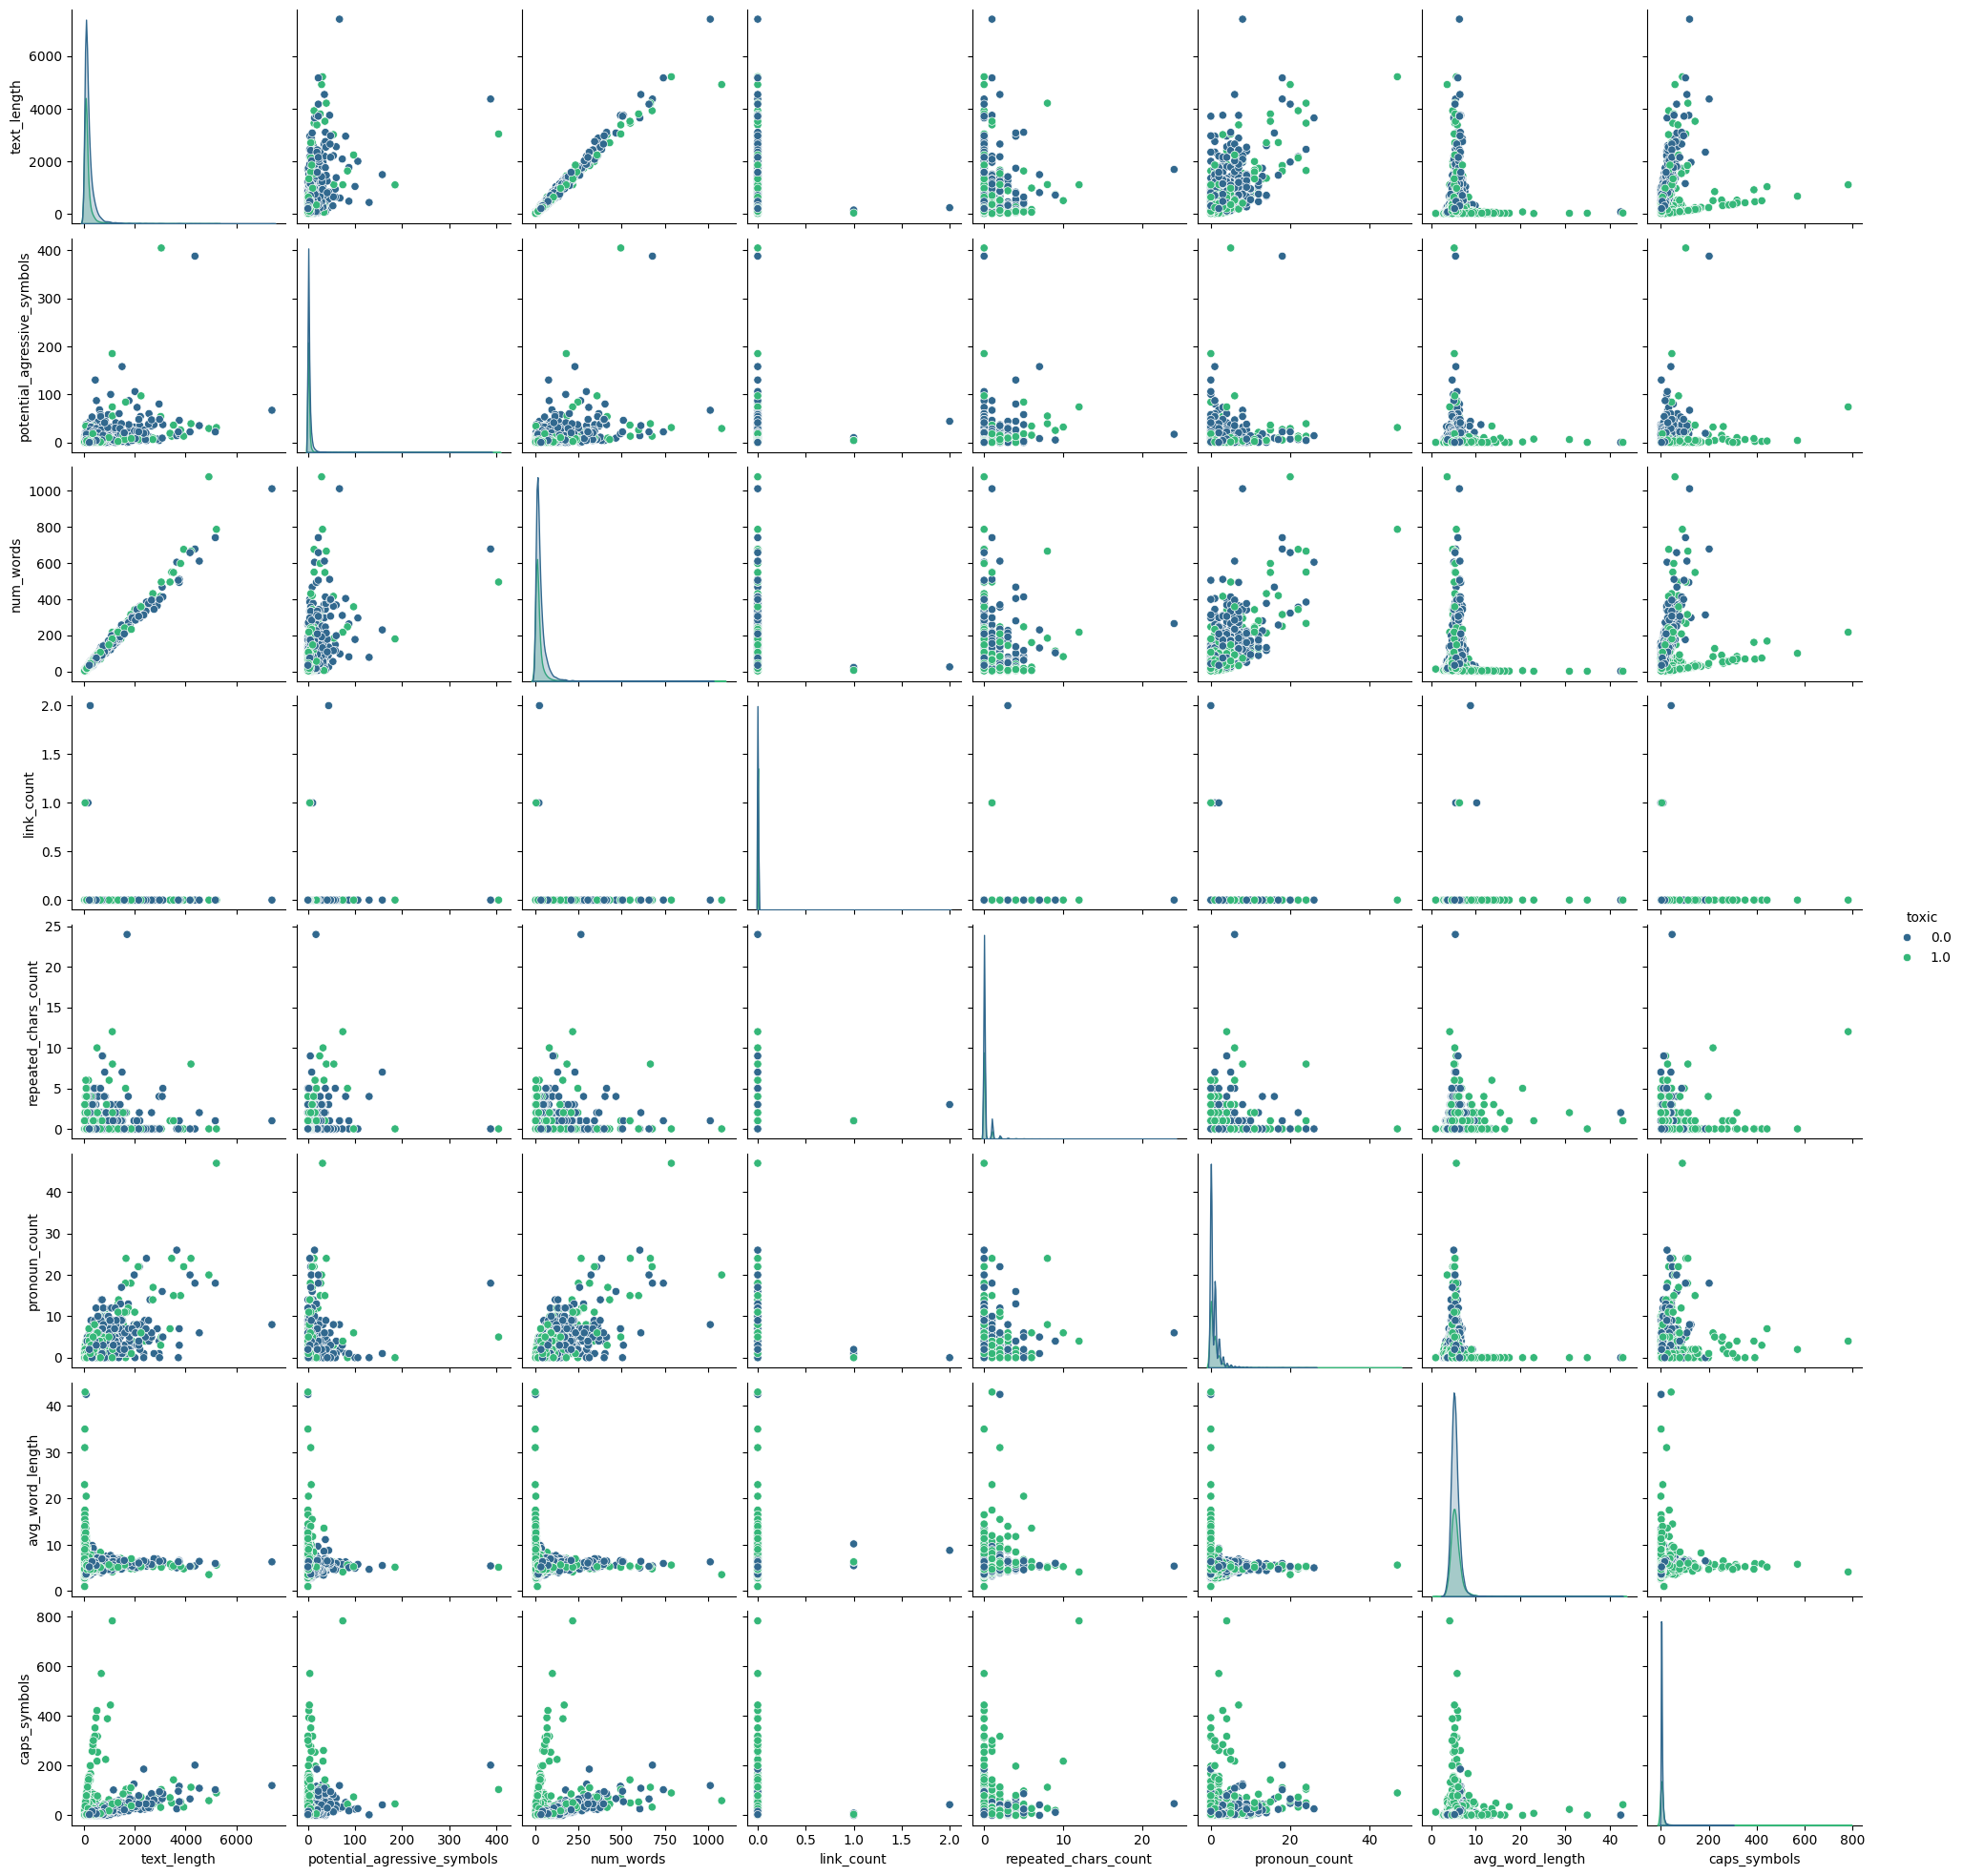

In [ ]:
sns.pairplot(comments_dataset, hue='toxic', palette='viridis')
plt.show()

2. Матрица корреляции

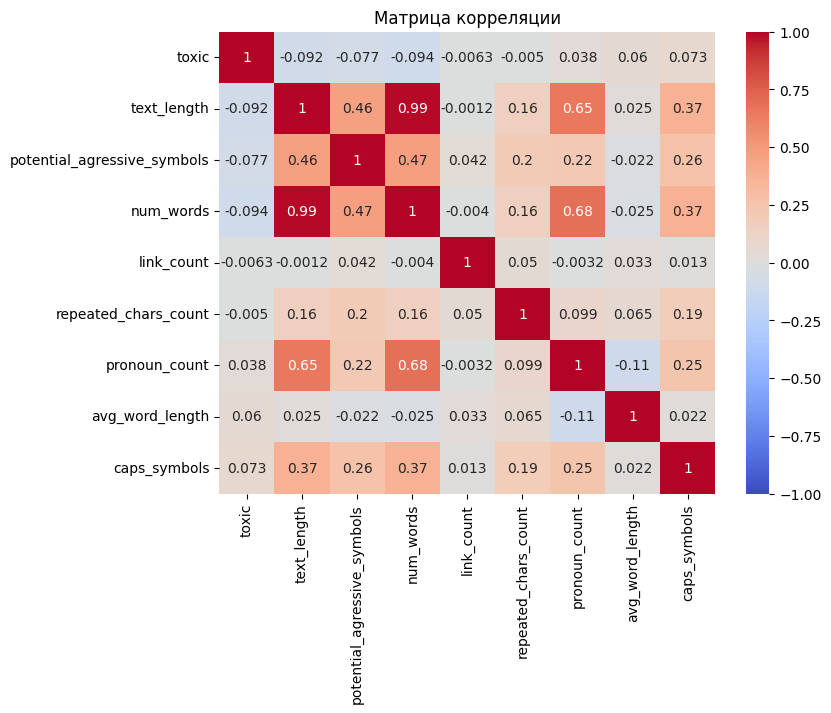

In [40]:
corr_matrix = comments_dataset.iloc[:, 1:].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляции')
plt.show()

Объективно, слабая корреляция

3. Feature Importance:

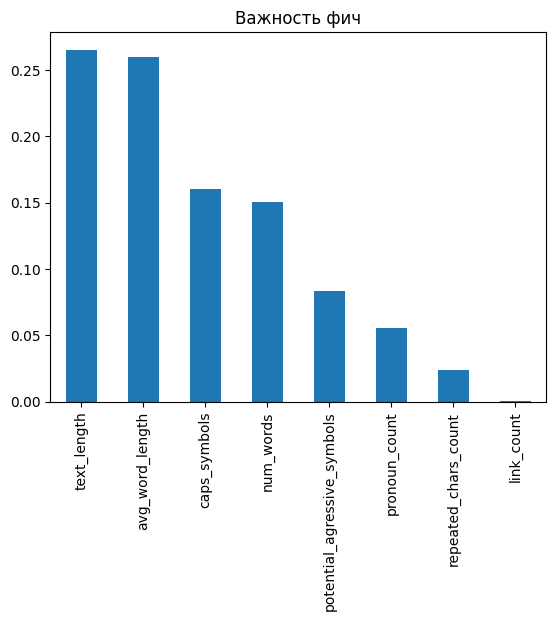

In [ ]:
X = comments_dataset.drop(columns=['toxic', 'comment'])
y = comments_dataset['toxic']

model = RandomForestClassifier()
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', title='Важность фич')
plt.show()

Какие-то фичи показали важность на Baseline решении (Random Forest Classifier)

Итоговый датасет

In [37]:
comments_dataset.head()

,comment,toxic,text_length,potential_agressive_symbols,num_words,link_count,repeated_chars_count,pronoun_count,avg_word_length,caps_symbols
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,35,1,5,0,1,0,6.000000,2
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,121,0,21,0,0,1,4.761905,2
2,Собаке - собачья смерть\n,1.0,24,0,4,0,0,0,5.000000,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,184,1,32,0,0,2,4.750000,3
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,120,5,18,0,0,0,5.666667,4


Сохранение датасета

In [47]:
comments_dataset.to_csv(SAVE_PROCESSED_PATH)

Итоги:

1. Проведен начальный анализ текстовых данных 

2. Проведен анализ важности извлеченных признаков

3. Извлеченные признаки показывают объективно слабое влияние на целевую переменную, но, возможно, могут быть использованы как некоторое дополнение к более сильной модели ```(дополнительные фичи и информация для модели).```